# TP Audio

In [20]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import scipy.signal
import tarfile
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras import layers, models

In [21]:
# Paramètres
target_words = ["up", "down", "left", "right"]
sampling_rate = 16000
time_frame = 30  # ms
stride = 10  # ms
n_mfcc = 40

In [22]:
def extract_features(file_path, max_pad_length=98):
    signal, sr = librosa.load(file_path, sr=sampling_rate)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)
    
    if mfccs.shape[1] < max_pad_length:
        pad_width = max_pad_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :max_pad_length]
    
    return mfccs

In [23]:
DATA_DIR = "data"

all_files = []
all_labels = []

for word in target_words:
    word_path = os.path.join(DATA_DIR, word)
    if os.path.exists(word_path):
        files = [os.path.join(word_path, f) for f in os.listdir(word_path) if f.endswith(".wav")]
        all_files.extend(files)
        all_labels.extend([word] * len(files))

X = np.array([extract_features(f) for f in all_files])
X = np.expand_dims(X, -1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(all_labels)
y = tf.keras.utils.to_categorical(y, num_classes=len(target_words))

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [24]:
def build_model(model_type):
    if model_type == "vanilla":
        model = models.Sequential([
            layers.Flatten(input_shape=X_train.shape[1:]),
            layers.Dense(len(target_words), activation='softmax')
        ])
    elif model_type == "dnn":
        model = models.Sequential([
            layers.Flatten(input_shape=X_train.shape[1:]),
            layers.Dense(128, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(target_words), activation='softmax')
        ])
    elif model_type == "cnn":
        model = models.Sequential([
            layers.Conv2D(64, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'), # i.e. fully-connected
            layers.Dense(len(target_words), activation='softmax')
        ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [25]:
models_dict = {name: build_model(name) for name in ["vanilla", "dnn", "cnn"]}

d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
d:\Users\norph\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training vanilla model...
Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4812 - loss: 13.4768 - val_accuracy: 0.6301 - val_loss: 3.6141
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6167 - loss: 4.0525 - val_accuracy: 0.6347 - val_loss: 3.4247
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6327 - loss: 3.3722 - val_accuracy: 0.6032 - val_loss: 4.2134
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6419 - loss: 3.2252 - val_accuracy: 0.5112 - val_loss: 6.0972
Epoch 5/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6638 - loss: 3.1090 - val_accuracy: 0.5841 - val_loss: 4.6431
Epoch 6/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6574 - loss: 3.0957 - val_accuracy: 0.5434 - val_loss: 5.3356
Epoch 7/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6514 - loss: 2.8823 - val_accuracy: 0.5591 - val_loss: 4.6055
Epoch 8/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6537 - los

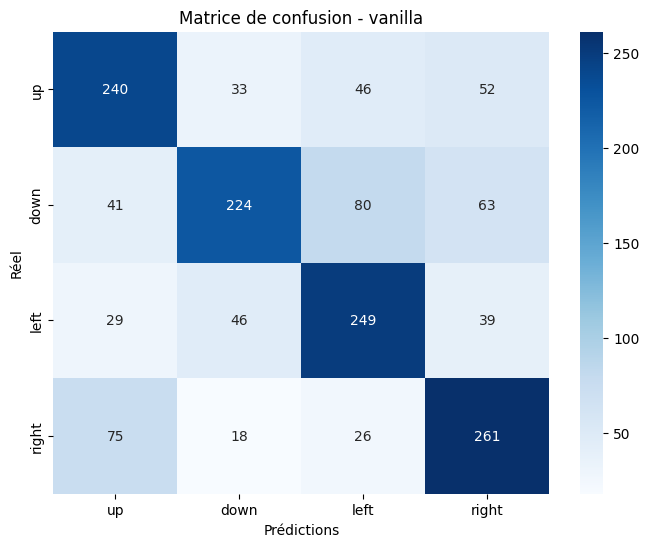

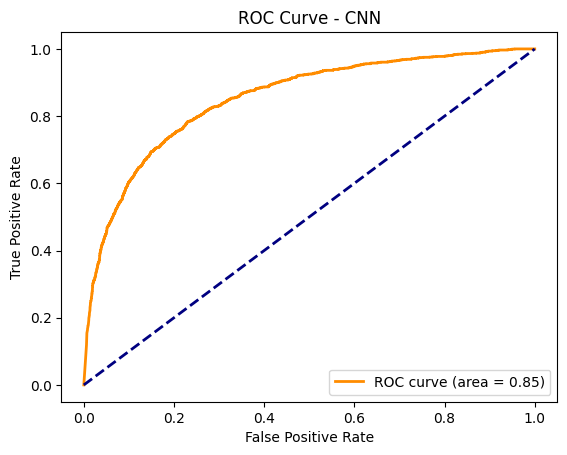

Classification Report:
              precision    recall  f1-score   support

          up       0.62      0.65      0.63       371
        down       0.70      0.55      0.61       408
        left       0.62      0.69      0.65       363
       right       0.63      0.69      0.66       380

    accuracy                           0.64      1522
   macro avg       0.64      0.64      0.64      1522
weighted avg       0.64      0.64      0.64      1522


Training dnn model...
Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5864 - loss: 3.4576 - val_accuracy: 0.7819 - val_loss: 0.6904
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8219 - loss: 0.5276 - val_accuracy: 0.7983 - val_loss: 0.6103
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8709 - loss: 0.3638 - val_accuracy: 0.7976 - val_loss: 0.6748
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8854 - loss: 0.3417 - val_accuracy: 0.8548 - val_loss: 0.5000
Epoch 5

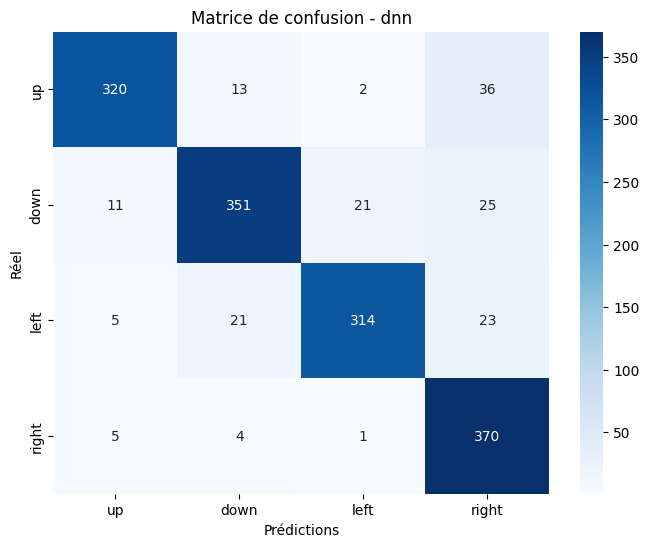

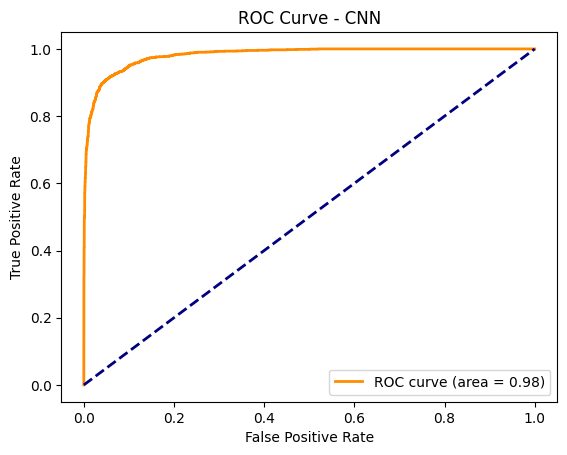

Classification Report:
              precision    recall  f1-score   support

          up       0.94      0.86      0.90       371
        down       0.90      0.86      0.88       408
        left       0.93      0.87      0.90       363
       right       0.81      0.97      0.89       380

    accuracy                           0.89      1522
   macro avg       0.90      0.89      0.89      1522
weighted avg       0.90      0.89      0.89      1522


Training cnn model...
Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 22s 56ms/step - accuracy: 0.4944 - loss: 2.0220 - val_accuracy: 0.8502 - val_loss: 0.3993
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.8761 - loss: 0.3305 - val_accuracy: 0.9113 - val_loss: 0.2365
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - accuracy: 0.9331 - loss: 0.1846 - val_accuracy: 0.9087 - val_loss: 0.2505
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9529 - loss: 0.1313 - val_accuracy: 0.9258 - val_loss: 0.2109

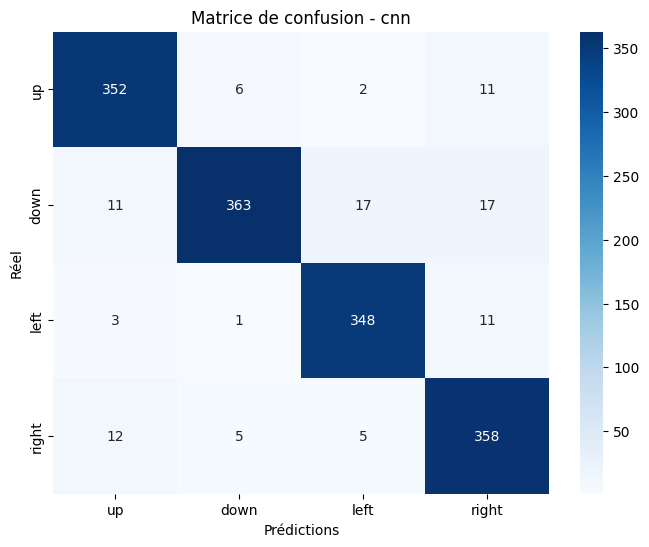

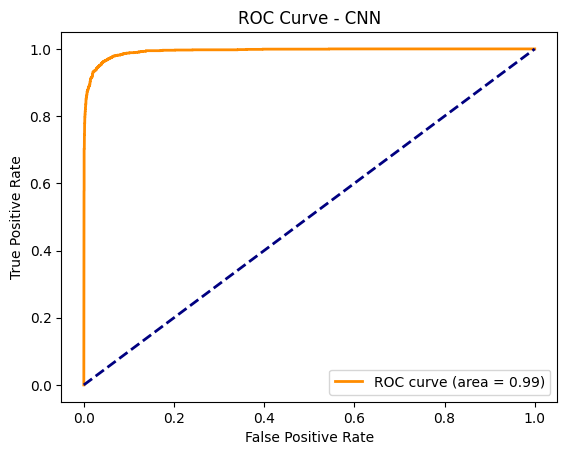

Classification Report:
              precision    recall  f1-score   support

          up       0.93      0.95      0.94       371
        down       0.97      0.89      0.93       408
        left       0.94      0.96      0.95       363
       right       0.90      0.94      0.92       380

    accuracy                           0.93      1522
   macro avg       0.93      0.93      0.93      1522
weighted avg       0.93      0.93      0.93      1522



In [26]:

for name, model in models_dict.items():
    print(f"\nTraining {name} model...")
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

    y_pred = models_dict[name].predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    conf_mat = confusion_matrix(y_test_labels, y_pred_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=target_words, yticklabels=target_words)
    plt.xlabel("Prédictions")
    plt.ylabel("Réel")
    plt.title(f"Matrice de confusion - {name}")
    plt.show()

    # plt.savefig(f"confusion_matrix_{name}.png")

    fpr, tpr, _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - CNN')
    plt.legend(loc='lower right')
    plt.show()

    # plt.savefig(f"roc_curve_{name}.png")

    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels, target_names=target_words))


TODO

- superposer du bruit (parcelles aléatoires de chacun des 6 types de bruits) aux fichiers du dataset d’entraînement
- tester quel est le volume de bruit idéal